## Laboratory 4: Simulation of a Spin-Based Quantum Reservoir Computer for time-series prediction

### 1 - Introduction

Quantum Reservoir Computing (QRC) is a paradigm that extends reservoir computing to quantum systems. A fixed (non-variational) quantum dynamical system acts as a reservoir that processes time-dependent inputs through its temporal evolution, while learning is restricted to a classical readout layer. This approach avoids training the internal quantum dynamics and makes QRC particularly suitable for near-term quantum devices (NISQ).

In spin-based QRC, the reservoir consists of interacting spins evolving under a fixed Hamiltonian. Classical inputs are injected sequentially by encoding them into the quantum state of boundary spins, which interact with the reservoir. This procedure induces an effective open-system dynamics that provides both nonlinearity and memory, key properties for time-series processing.

In this laboratory, you will simulate a spin-based quantum reservoir computer for time-series prediction. You will implement amplitude encoding of inputs, simulate the density-matrix evolution of the reservoir, and extract classical features from quantum measurements. A linear readout will then be trained to predict future values of a temporal signal (a chaotic time series from the Lorenz System).

The objective of this lab is to understand how quantum dynamics, input encoding, and measurement combine to produce computational capabilities, and to gain hands-on experience with the simulation and evaluation of a quantum reservoir computing systems.

### 2 - Spin-based Quantum Reservoir Computing Modelling

To simulate the quantum reservoir computer, We will uses an Hamiltonian describing interactions between spins (similar to that present in class) and following the mathematical form highlighted in the following reference : ***Quantum reservoir computing: a reservoir approach toward quantum machine learning on near-term quantum devices***: https://arxiv.org/abs/2011.04890

The mathemetical form of the hamiltonian reads :

$$H = \sum_{i,j} J_{i,j} X_i X_j + h \sum_i Z_i$$

with $X_i = I \otimes I ... \otimes I \otimes X \otimes I ... \otimes I$, $X$ the Pauli-X operator, and $I$ the identity operator acting on a single qubit.

For example, Consideriong a QRC with two nodes, we would have :
- $X_0 = X \otimes I$
- $X_1 = I \otimes X$

 ## Work to do

### 3-Implementation Of Operators

***Question 1*** :   Create in Numpy the matrices for the $X$, $Y$, $Z$  Pauli operators and $I$ the identity operator.

In [38]:
import numpy as np



In [39]:
I = np.array([[1, 0], 
              [0, 1]], dtype=complex)


X = np.array([[0, 1], 
              [1, 0]], dtype=complex)


Y = np.array([[0, -1j], 
              [1j, 0]], dtype=complex)


Z = np.array([[1, 0], 
              [0, -1]], dtype=complex)

print("Matrice I:\n", I)
print("Matrice X:\n", X)
print("Matrice Y:\n", Y)
print("Matrice Z:\n", Z)

Matrice I:
 [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Matrice X:
 [[0.+0.j 1.+0.j]
 [1.+0.j 0.+0.j]]
Matrice Y:
 [[ 0.+0.j -0.-1.j]
 [ 0.+1.j  0.+0.j]]
Matrice Z:
 [[ 1.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j]]


***Question 2*** :  Create in Numpy the matrices for operators $X_i$, $Z_i$.

In [40]:
# TODO return the numpy version of Xi
def Xi(nb_node, i):
    if i == 0:
        res = X
    else:
        res = I
    for j in range(1, nb_node):
        if j == i :
            res = np.kron(res, X)
        else :
            res = np.kron(res, I)
    return res

In [41]:
# TODO return the numpy version of Zi
def Zi(nb_node, i):
    if i == 0:
        res = Z
    else:
        res = I
    for j in range(1, nb_node):
        if j == i :
            res = np.kron(res, Z)
        else :
            res = np.kron(res, I)
    return res

***Question 3*** :   Create in Numpy the matrix for the Hamiltonian operator using the expression shown in Section 2. The interaction being bidirectional, the adjacency of matrix of the network containing coefficient $J_{i,j}$ is squared and symmetric (Note : the transverse field coefficients $h$ are on the diagonal on matrix).

In [42]:
# TODO return the numpy Hamiltonian for the given weigth
def make_Hamiltonian(nb_node, weight):
    res = np.zeros((2**nb_node, 2**nb_node), dtype=complex)

    # 1. Terme d'interaction
    for i in range(nb_node):
        for j in range(nb_node):
            if i != j:
                J_ij = weight[i, j]
                res += J_ij * (Xi(nb_node, i) @ Xi(nb_node, j))

    # 2. Terme de champ transverse
    for i in range(nb_node):
        h_i = weight[i, i]
        res += h_i * Zi(nb_node, i)

    return res

In [43]:
make_Hamiltonian(2, np.array([[1.0,0.2], [0.2, 1.0]]))

array([[ 2. +0.j,  0. +0.j,  0. +0.j,  0.4+0.j],
       [ 0. +0.j,  0. +0.j,  0.4+0.j,  0. +0.j],
       [ 0. +0.j,  0.4+0.j,  0. +0.j,  0. +0.j],
       [ 0.4+0.j,  0. +0.j,  0. +0.j, -2. +0.j]])

### 4- Data input

The following code allows to easily compute the partial trace for an operator. This will be a useful function for the computation of the temporal evolution of the density operator describiung aggregated state of the reservoir and boundary input qubits

In [44]:
# https://github.com/cvxpy/cvxpy/issues/563#issuecomment-414081249

def partial_trace(rho, dims, axis=0):
    """
    Takes partial trace over the subsystem defined by 'axis'
    rho: a matrix
    dims: a list containing the dimension of each subsystem
    axis: the index of the subsytem to be traced out
    (We assume that each subsystem is square)
    """
    dims_ = np.array(dims)
    # Reshape the matrix into a tensor with the following shape:
    # [dim_0, dim_1, ..., dim_n, dim_0, dim_1, ..., dim_n]
    # Each subsystem gets one index for its row and another one for its column
    reshaped_rho = rho.reshape(np.concatenate((dims_, dims_), axis=None))

    # Move the subsystems to be traced towards the end
    reshaped_rho = np.moveaxis(reshaped_rho, axis, -1)
    reshaped_rho = np.moveaxis(reshaped_rho, len(dims)+axis-1, -1)

    # Trace over the very last row and column indices
    traced_out_rho = np.trace(reshaped_rho, axis1=-2, axis2=-1)

    # traced_out_rho is still in the shape of a tensor
    # Reshape back to a matrix
    dims_untraced = np.delete(dims_, axis)
    rho_dim = np.prod(dims_untraced)
    return traced_out_rho.reshape([rho_dim, rho_dim])

***Question 4*** :  We will inject the normalized data $x$ by replacing a node values with $\frac{I + (2x-1)Z}{2}$. Return the matrix corresponding to the normalized data x

In [45]:
# TODO return the matrix corresponding to the normalized data x
def input_matrix(data):
    x = data
    rho_x = (I + (2*x - 1) * Z) / 2
    return rho_x

***Question 5*** : To replace the node values with new ones, we extract the values of the nodes we want to keep using the partial trace. Then we perform a tensorial product with the matrices of the new values.

In [46]:
# TODO input_data take the density matrix and replace the node value by the new input
def input_data(nb_node, density_matrix, list_data):
    M = len(list_data) 
    dims = [2] * nb_node
    rho_rest = density_matrix
    
    # On retire les qubits à remplacer
    for _ in range(M):
        rho_rest = partial_trace(rho_rest, dims, axis=0)
        dims.pop(0) 
        
    # [Nouveau bloc d'entrée] 
    rho_in = np.array([[1]]) 
    for data in list_data:
        rho_in = np.kron(rho_in, input_matrix(data))
        
    # [Nouveau bloc d'entrée] ⊗ [Reste du réservoir]
    return np.kron(rho_in, rho_rest)

In [47]:
density_matrix = np.zeros((2**3, 2**3))
density_matrix[0,0] = 1
input_data(3, density_matrix, [0.1, 0.2])

array([[0.02+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.08+0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.18+0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.72+0.j, 0.  +0.j],
       [0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j, 0.  +0.j,
        0.  +0.j, 0.  +0.j]])

### 5 - Observable

***Question 6*** : We will recover the values of the observables $Z_i$ renormalized between 0 and 1 as observables.

In [48]:
# TODO observable return the Zi observable values
def observable(nb_node, density_matrix):
    res = []
    for i in range(nb_node):
        result = np.trace( Zi(nb_node, i) @ density_matrix)
        result_renorm = (result.real + 1 )/2
        res.append(result_renorm)
    return res

### 6 - Reservoir Evolution

In [49]:
from scipy.linalg import expm # Do the exponentielle of matrix

We are now going to evolve our reservoir.

To do this, we will follow these steps:
- We inject the data in the density_matrix with ```input_data``` function.
- We make the reservoir evolve during a time $t$ with the Schrödinger equation.
- We stock the observable as results.
- We start again with the next piece of data.

-------------------------------------------

For a density matrix $\rho$ and a time-independent Hamiltonian $H$, the Schrödinger equation describing the evolution of the system over a time period $t$ is as follows:

$\rho' = \exp(-iHt) \rho \exp(iHt)$

-------------------------------------------

In addition to all this, we will introduce the concept of virtual nodes:
We measure our system several times between two injections. So instead of evolving our system for a period of time $t$ after injecting the data, we evolve it as many times as there are virtual nodes $nb\_virtual\_node$ for a period of time $t/nb\_virtual\_node$.


***Question 7*** : Implement the evolution of the reservoir.

In [50]:
def Reservoir(nb_node, weight, list_of_data, t=1.0, nb_virtual=10):
    # Ici data est une liste de listes  de données !! Une
    # TODO Make a reservoir Hamiltonian
    H = make_Hamiltonian(nb_node, weight)

    # Initialize the density matrix
    density_matrix = np.zeros((2**nb_node, 2**nb_node))
    density_matrix[0,0] = 1

    # List of results
    res = []
    U_virtual = expm(-1j * H * (t / nb_virtual))
    U_virtual_dag = U_virtual.conj().T

    # TODO inject the list_data in the density matrix
    
    for data_vector in list_of_data:
        # List of virtual nodes
        aux=[]
        # TODO inject the data x in the density matrix
        density_matrix = input_data(nb_node, density_matrix, data_vector)
        for v in range(nb_virtual):
            # TODO Evolve the reservoir during a time t/nb_virtual
            density_matrix = U_virtual @ density_matrix @ U_virtual_dag

            # TODO calculate the observables and store them in the virtual node list
            aux += observable(nb_node, density_matrix)
        res.append(aux)
    return np.array(res)

### 7 - A first test: Lorenz attractor

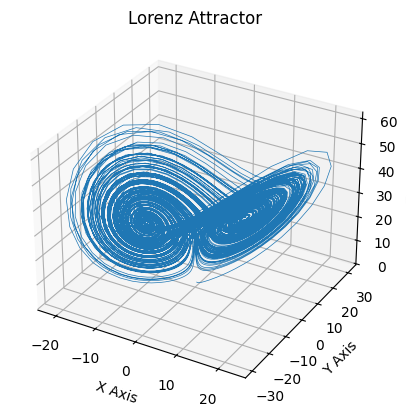

In [51]:
import matplotlib.pyplot as plt

# https://matplotlib.org/stable/gallery/mplot3d/lorenz_attractor.html

def lorenz(xyz, *, s=10, r=28, b=2.667):
    """
    Parameters
    ----------
    xyz : array-like, shape (3,)
       Point of interest in three-dimensional space.
    s, r, b : float
       Parameters defining the Lorenz attractor.

    Returns
    -------
    xyz_dot : array, shape (3,)
       Values of the Lorenz attractor's partial derivatives at *xyz*.
    """
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

dt = 0.02
num_steps = 11000

xyzs = np.empty((num_steps + 1, 3))  # Need one more for the initial values
xyzs[0] = (0., 1., 1.05)  # Set initial values
# Step through "time", calculating the partial derivatives at the current point
# and using them to estimate the next point
for i in range(num_steps):
    xyzs[i + 1] = xyzs[i] + lorenz(xyzs[i]) * dt

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyzs.T, lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

plt.show()

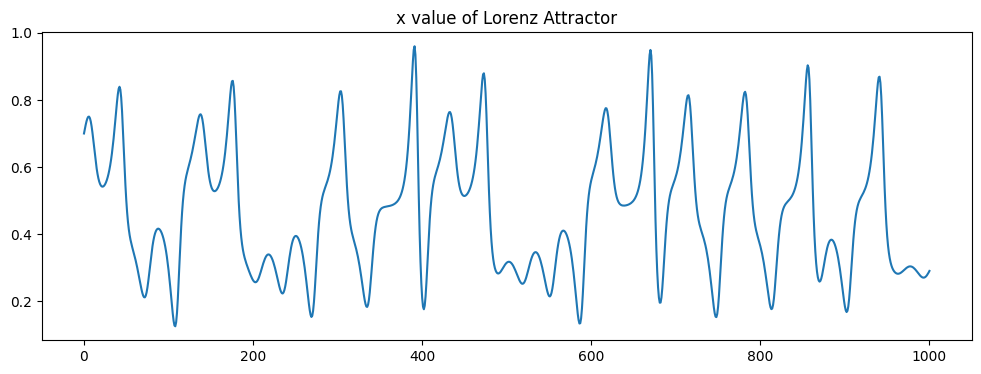

In [52]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
xyzs = min_max_scaler.fit_transform(xyzs)
x_value = xyzs[:,0].reshape(-1, 1)
plt.subplots(figsize=(12, 4))
plt.title("x value of Lorenz Attractor")
plt.plot(x_value[10000:], label='x')

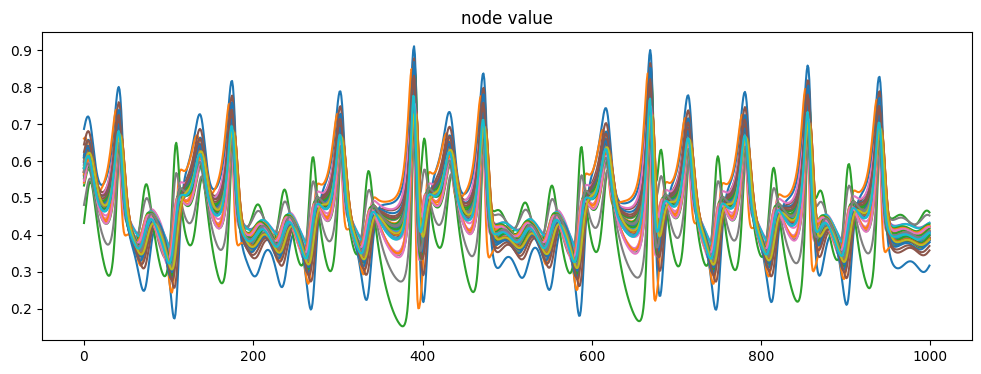

In [53]:
# generate random weight for the reservoir
def generated_weight(nb_node):
    X = np.random.rand(nb_node, nb_node) - 0.5
    X[np.diag_indices_from(X)] = np.ones(nb_node)
    return X

weigth_reservoir = generated_weight(5)

embedded_data = Reservoir(5, weigth_reservoir, xyzs, t=4.0)
plt.subplots(figsize=(12, 4))
plt.title("node value")
plt.plot(embedded_data[-1000:,:])

**Commentaire**

Le nombre de caractéristiques (features) est ici considérablement augmenté. Initialement, les données étaient limitées aux trois dimensions spatiales de l'attracteur. Dans cette configuration de réservoir quantique, l'utilisation de 5 observables couplée à 10 nœuds virtuels génère un total de 50 caractéristiques. C'est précisément ici que réside tout l'intérêt du réservoir et du multiplexage temporel (nœuds virtuels) : projeter un signal simple dans un espace de Hilbert de haute dimension pour en extraire une dynamique complexe.

### 8 - prediction without reservoir: Lorenz attractor

In [54]:
# calculWeights calculate the pseudo inverse matrix (linear regression) y = x*W
def calculWeights(x,y):
    Xinv = np.linalg.pinv(x)
    Y = np.array(y)
    return np.matmul(Xinv, Y)

Here is an example where we use the first 10,000 data points to obtain the W matrix where $xyzs_{k+1} = xyzs{k}*W$. We then use the matrix to predict the last 1,000 steps.

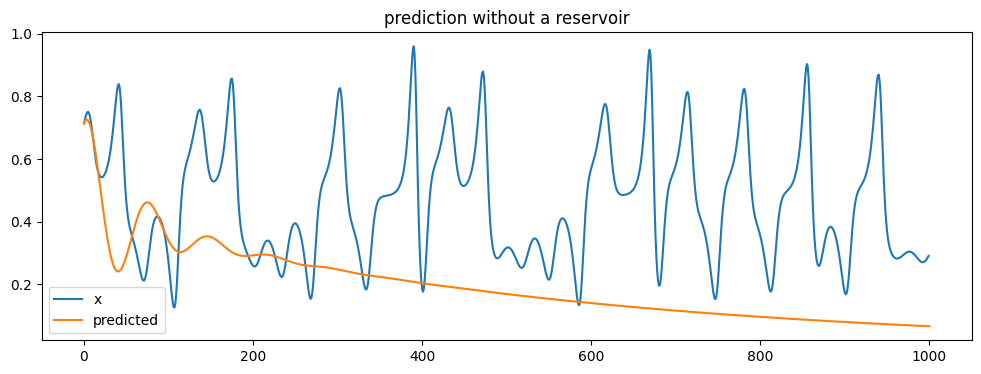

In [55]:
steps = 1000 # number of steps to predict
weights = calculWeights(xyzs[:-1*steps-1,:], xyzs[1:-1*steps,:])
x_predict = [xyzs[-1*steps,:]]
for i in range(steps):
    x_predict.append(np.matmul(x_predict[-1], weights))
x_predict = np.array(x_predict)

plt.subplots(figsize=(12, 4))
plt.title("prediction without a reservoir")
plt.plot(x_value[-1*steps:], label='x')
plt.plot(x_predict[:,0], label='predicted')
plt.legend()

**Commentaire**

Ce graphique illustre la difficulté de modéliser un système chaotique comme l'attracteur de Lorenz à l'aide d'une simple régression linéaire. En utilisant uniquement les trois coordonnées spatiales comme entrées, la prédiction basée sur la pseudo-inverse diverge presque instantanément, dès les dix premiers pas de temps. Cela démontre que les corrélations linéaires directes sont insuffisantes pour capturer la topologie de cet attracteur.

### 9 - prediction with reservoir: Lorenz attractor

#### 9-1 Prediction 1-steps

***Question 8*** : Here we will test the short-term prediction capability. We will pass our entire time series through the reservoir, then use the first 10,000 points to perform a linear regression $xyzs_{k+1} = reservoir(xyzs_{k}) * W $ then use the $W$ weigth to see the prediction for the last 1,000 points. Basically, we predict the next point each time based on the true sequence.

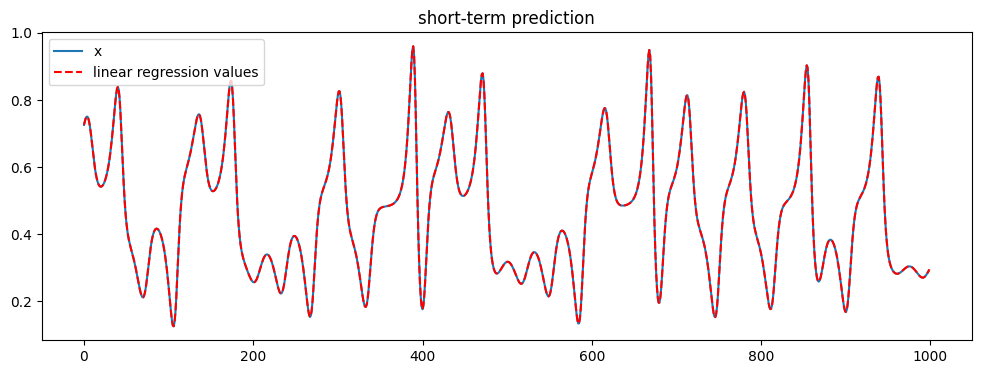

In [56]:
steps = 1000

reservoir_result = Reservoir(5, weigth_reservoir, xyzs, t=4.0)

# TODO calcul the Weights (linear regression) as in the previous example (use the first 10,000 data points to calculate the weights)
weights = calculWeights(reservoir_result[:-steps-1, :], xyzs[1:-steps, :])

# TODO predict the last 1000 points
x_predict = reservoir_result[-steps:, :] @ weights

plt.subplots(figsize=(12, 4))
plt.title("short-term prediction")
plt.plot(x_value[-1000+1:], label='x')
# TODO display predicted points
plt.plot(x_predict[:,0], label='linear regression values', color='red', linestyle='--')
plt.legend()

**Commentaire**

L'efficacité du réservoir est démontrée avec succès dans le cas de la prédiction à court terme. L'expansion de l'espace des caractéristiques permet de prédire avec une grande précision l'évolution immédiate du système chaotique, car le modèle bénéficie de la "mémoire" et de la non-linéarité induites par la dynamique des spins.

#### 9-2 Prediction N-steps

***Question 9*** : Now we want to use the first 10,000 data points in the sequence to determine $W$, then we will use the formula  $xyzs_{k+1} = reservoir(xyzs_{k}) * W $ to predict $xyzs_{k+1}$ and then inject it into the reservoir, and so on. We are making a long-term prediction.

In [ ]:
def predict(nb_node, weight, data, steps, t=1.0, nb_virtual=10):

    # TODO Make a reservoir Hamiltonian
    H = make_Hamiltonian(nb_node, weight)

    # Initialize the density matrix
    density_matrix = np.zeros((2**nb_node, 2**nb_node))
    density_matrix[0,0] = 1

    U_virtual = expm(-1j * H * (t / nb_virtual))
    U_virtual_dag = U_virtual.conj().T


    # List of results
    res = []

    for x in data:
        # List of virtual nodes
        aux=[]
        # TODO inject the data x in the density matrix
        density_matrix = input_data(nb_node, density_matrix, x)

        for v in range(nb_virtual):
            # TODO Evolve the reservoir during a time t/nb_virtual
            density_matrix = U_virtual @ density_matrix @ U_virtual_dag


            # TODO calculate the observables and store them in the virtual node list
            aux += observable(nb_node, density_matrix)

        res.append(aux)
    res = np.array(res)

    # TODO calcul the Weights (linear regression)
    weights = calculWeights(res[:-steps-1, :], data[1:-steps, :])


    # TODO predict the initial new data
    new_data_init = res[-1, :] @ weights
    new_data = [new_data_init]

    for i in range(steps):
        aux=[]
        # TODO inject the last data predicted in the density matrix
        density_matrix = input_data(nb_node, density_matrix, new_data[-1])

        for v in range(nb_virtual):
            # TODO Evolve the reservoir during a time t/nb_virtual
            density_matrix = U_virtual @ density_matrix @ U_virtual_dag

            # TODO calculate the observables and store them in the virtual node list
            aux += observable(nb_node, density_matrix)

        # TODO Using the new result from the reservoir and the previously calculated weights, predict the new value.
        #      And added it to the new_data list
        new_value = np.matmul(aux, weights)
        new_data.append(new_value)
        

    return np.array(new_data)

***Question 10*** : Predict the last n steps of the sequence and display them.

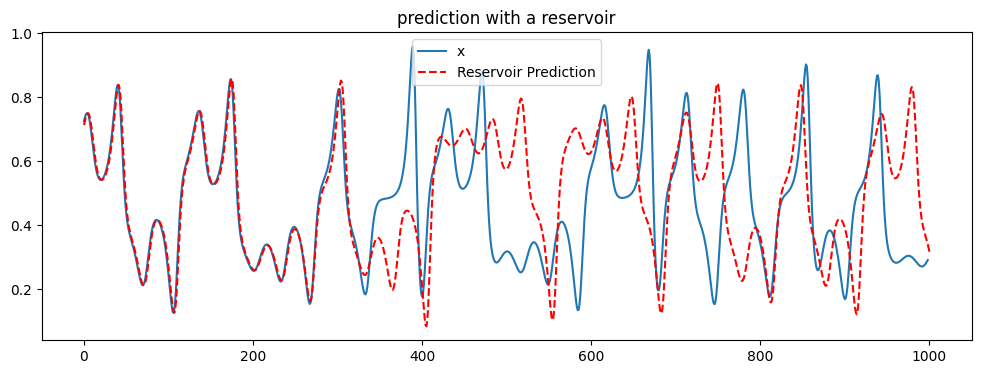

In [58]:
n_steps = 1000
new_data = predict(5, weigth_reservoir, xyzs[:-1*n_steps], n_steps, t=4.0)
# 50 features
plt.subplots(figsize=(12, 4))
plt.title("prediction with a reservoir")
plt.plot(x_value[-1000+1:], label='x')
# TODO display predicted points
plt.plot(new_data[:, 0], label='Reservoir Prediction', color='red', linestyle='--')
plt.legend()

**Commentaire**

Bien que les résultats restent supérieurs à une régression linéaire classique, la performance est moindre par rapport à la prédiction à court terme. Cela est attendu, car nous sommes ici en mode de prédiction autonome (ou récursive) sur 1 000 points : chaque erreur de prédiction est réinjectée dans le réservoir, entraînant une divergence graduelle typique des systèmes sensibles aux conditions initiale

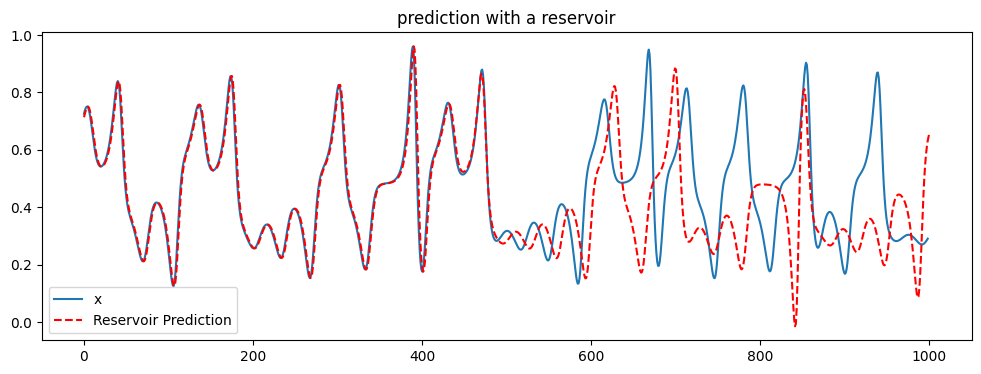

In [59]:
n_steps = 1000
new_data = predict(5, weigth_reservoir, xyzs[:-1*n_steps], n_steps, t=4.0, nb_virtual=20)
# 100 features
plt.subplots(figsize=(12, 4))
plt.title("prediction with a reservoir")
plt.plot(x_value[-1000+1:], label='x')
# TODO display predicted points
plt.plot(new_data[:, 0], label='Reservoir Prediction', color='red', linestyle='--')
plt.legend()

**Commentaire**

L'augmentation du nombre de caractéristiques via les nœuds virtuels améliore significativement la précision du modèle. On observe que le temps d'exécution croît de manière linéaire avec le nombre de nœuds virtuels ($nb\_virtual$), confirmant que cette technique est un levier efficace pour enrichir le réservoir à moindre coût computationnel, bien qu'une analyse plus fine de la convergence soit nécessaire

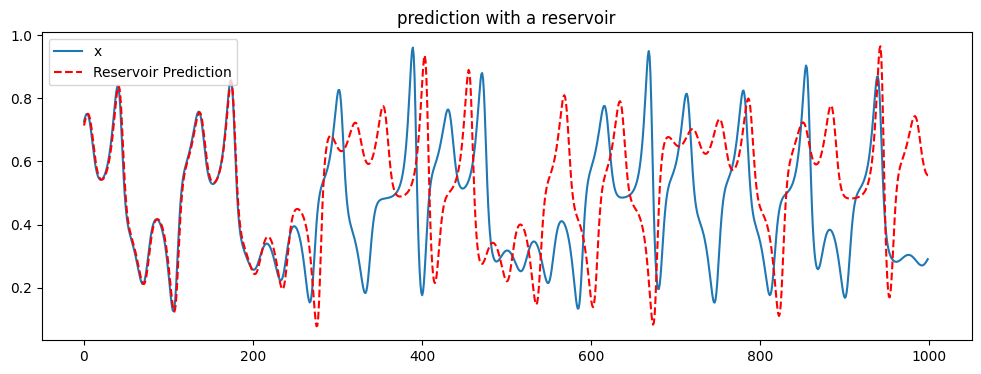

In [60]:
n_steps = 1000

weigth_reservoir = generated_weight(6)
new_data = predict(6, weigth_reservoir, xyzs[:-1*n_steps], n_steps, t=4.0, nb_virtual=10)
# 60 features 
plt.subplots(figsize=(12, 4))
plt.title("prediction with a reservoir")
plt.plot(x_value[-1000+1:], label='x')
# TODO display predicted points
plt.plot(new_data[:, 0], label='Reservoir Prediction', color='red', linestyle='--')
plt.legend()

**Commentaire**

Augmenter le nombre de qubits de 5 à 6 n'a pas produit d'amélioration notable de la précision, le gain en nombre de caractéristiques restant marginal dans ce test. En revanche, le coût de calcul a augmenté de façon beaucoup plus radicale, ce qui illustre la complexité exponentielle liée à la simulation de la matrice de densité ($2^N \times 2^N$) sur du matériel classique.